In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from queue import Queue
import matplotlib as mpl


In [25]:
images = [cv2.imread(f"Images/image{i}.png", cv2.IMREAD_COLOR)[:, :, ::-1] for i in range(1, 8)]
for i in range(len(images)):
    images[i] = cv2.resize(images[i], (int(images[i].shape[1] * 800 / images[i].shape[0]), 800))

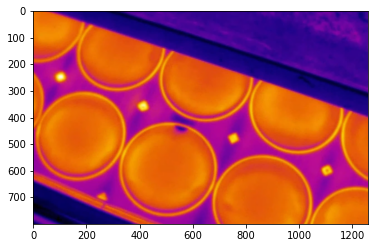

In [3]:
mpl.rcParams['figure.dpi'] = 100
plt.imshow(images[1])

## First, trying to do so with some basic methods that work with binary dilation and erosion

We can see that the blue channel has a lot of difference on objects we need to count and background. Lets' try to make a binary image out of it using thresholding, and working with these binary images afterwards. Here, I saw that the most interesting information is stored in green and blue channels, so I transform the image to grayscale using just them in a way to make objects distinguishable


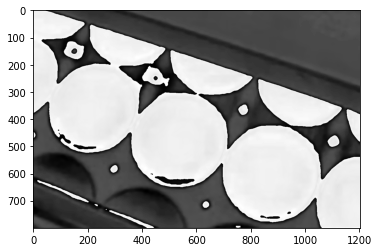

In [4]:
image_idx = 0
img = images[image_idx].copy()

# Remove noise by using the median filter
img = cv2.medianBlur(img, 11)
plt.imshow(img[:, :, 2] // 2 - img[:, :, 1] // 6, cmap='gray')

#### Looks like objects should be easily distinguishable after some thresholding

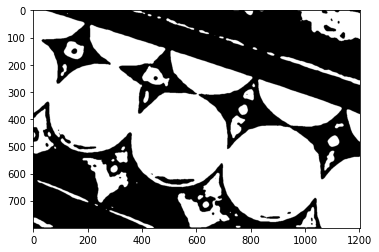

In [5]:
blur = cv2.GaussianBlur(img, (5, 5), 0)
ret, th = cv2.threshold(blur[:, :, 2] // 2 - blur[:, :, 1] // 6, 75, 255, cv2.THRESH_BINARY)
plt.imshow(th, cmap='gray')

#### Now applying dilation and erostion to get rid of not needed details and to separate objects

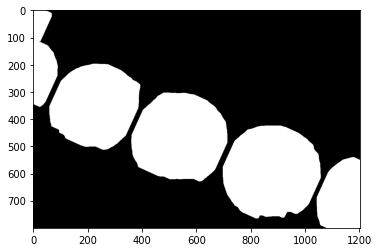

In [6]:
kernel = np.zeros((55, 25), dtype=np.uint8)
cv2.line(kernel, (0, 55), (25, 0), thickness=4, color=255)

kernel2 = np.zeros((25, 55), dtype=np.uint8)
cv2.line(kernel2, (0, 0), (55, 25), thickness=4, color=255)
plt.imshow(kernel2, cmap='gray')

opened_image = cv2.morphologyEx(th, cv2.MORPH_ERODE, kernel)
opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_ERODE, kernel)
opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_ERODE, kernel2)

opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_DILATE, kernel)
opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_DILATE, kernel)
opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_DILATE, kernel2)

# opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_ERODE, kernel)

plt.imshow(opened_image, cmap='gray')


#### Now I count size of each individual objects in pixels, and select only ones larget than 50000 pixels and that are not touching sides of the image.

### And a combined version of all above with all of the images

In [26]:

object_locations = []

for image_idx in range(7):
    img = images[image_idx].copy()
    img = cv2.resize(img, (int(img.shape[1] * 800 / img.shape[0]), 800))

    # Remove noise by using the median filter
    img = cv2.medianBlur(img, 11)

    blur = cv2.GaussianBlur(img, (5, 5), 0)
    ret, th = cv2.threshold(blur[:, :, 2] // 2 - blur[:, :, 1] // 6, 75, 255, cv2.THRESH_BINARY)

    kernel = np.zeros((55, 25), dtype=np.uint8)
    cv2.line(kernel, (0, 55), (25, 0), thickness=4, color=255)

    kernel2 = np.zeros((25, 55), dtype=np.uint8)
    cv2.line(kernel2, (0, 0), (55, 25), thickness=4, color=255)

    opened_image = cv2.morphologyEx(th, cv2.MORPH_ERODE, kernel)
    opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_ERODE, kernel)
    opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_ERODE, kernel2)

    opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_DILATE, kernel)
    opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_DILATE, kernel)
    opened_image = cv2.morphologyEx(opened_image, cv2.MORPH_DILATE, kernel2)

    objects, contours = cv2.findContours(opened_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    valid = 0

    object_locations.append([])

    dx = [-1, -1, 0, 1, 1, 1, 0, -1]
    dy = [0, 1, 1, 1, 0, -1, -1, -1]

    for obj in objects:
        s = cv2.contourArea(obj)
        contour_max = np.max(obj, axis=0)[0]
        contour_min = np.min(obj, axis=0)[0]

        # If contour touches the image border - discard it
        if contour_min[0] == 0 or contour_min[1] == 0 or contour_max[1] == opened_image.shape[0] - 1 or contour_max[
            0] == opened_image.shape[1] - 1:
            may_be_valid = False
        else:
            may_be_valid = True

        # If contour is too small - discard it
        if may_be_valid and s > 50000:
            s_x, s_y = contour_min + (contour_max - contour_min) / 2
            object_locations[-1].append((s_x, s_y))
            valid += 1
    #
    print(f"For image {image_idx + 1} the algorithm found {valid} objects on the image")
    # should be 3 2 2 1 2 2 1

For image 1 the algorithm found 3 objects on the image
For image 2 the algorithm found 2 objects on the image
For image 3 the algorithm found 2 objects on the image
For image 4 the algorithm found 1 objects on the image
For image 5 the algorithm found 2 objects on the image
For image 6 the algorithm found 2 objects on the image
For image 7 the algorithm found 1 objects on the image


#### Plotting the result with marked object centers

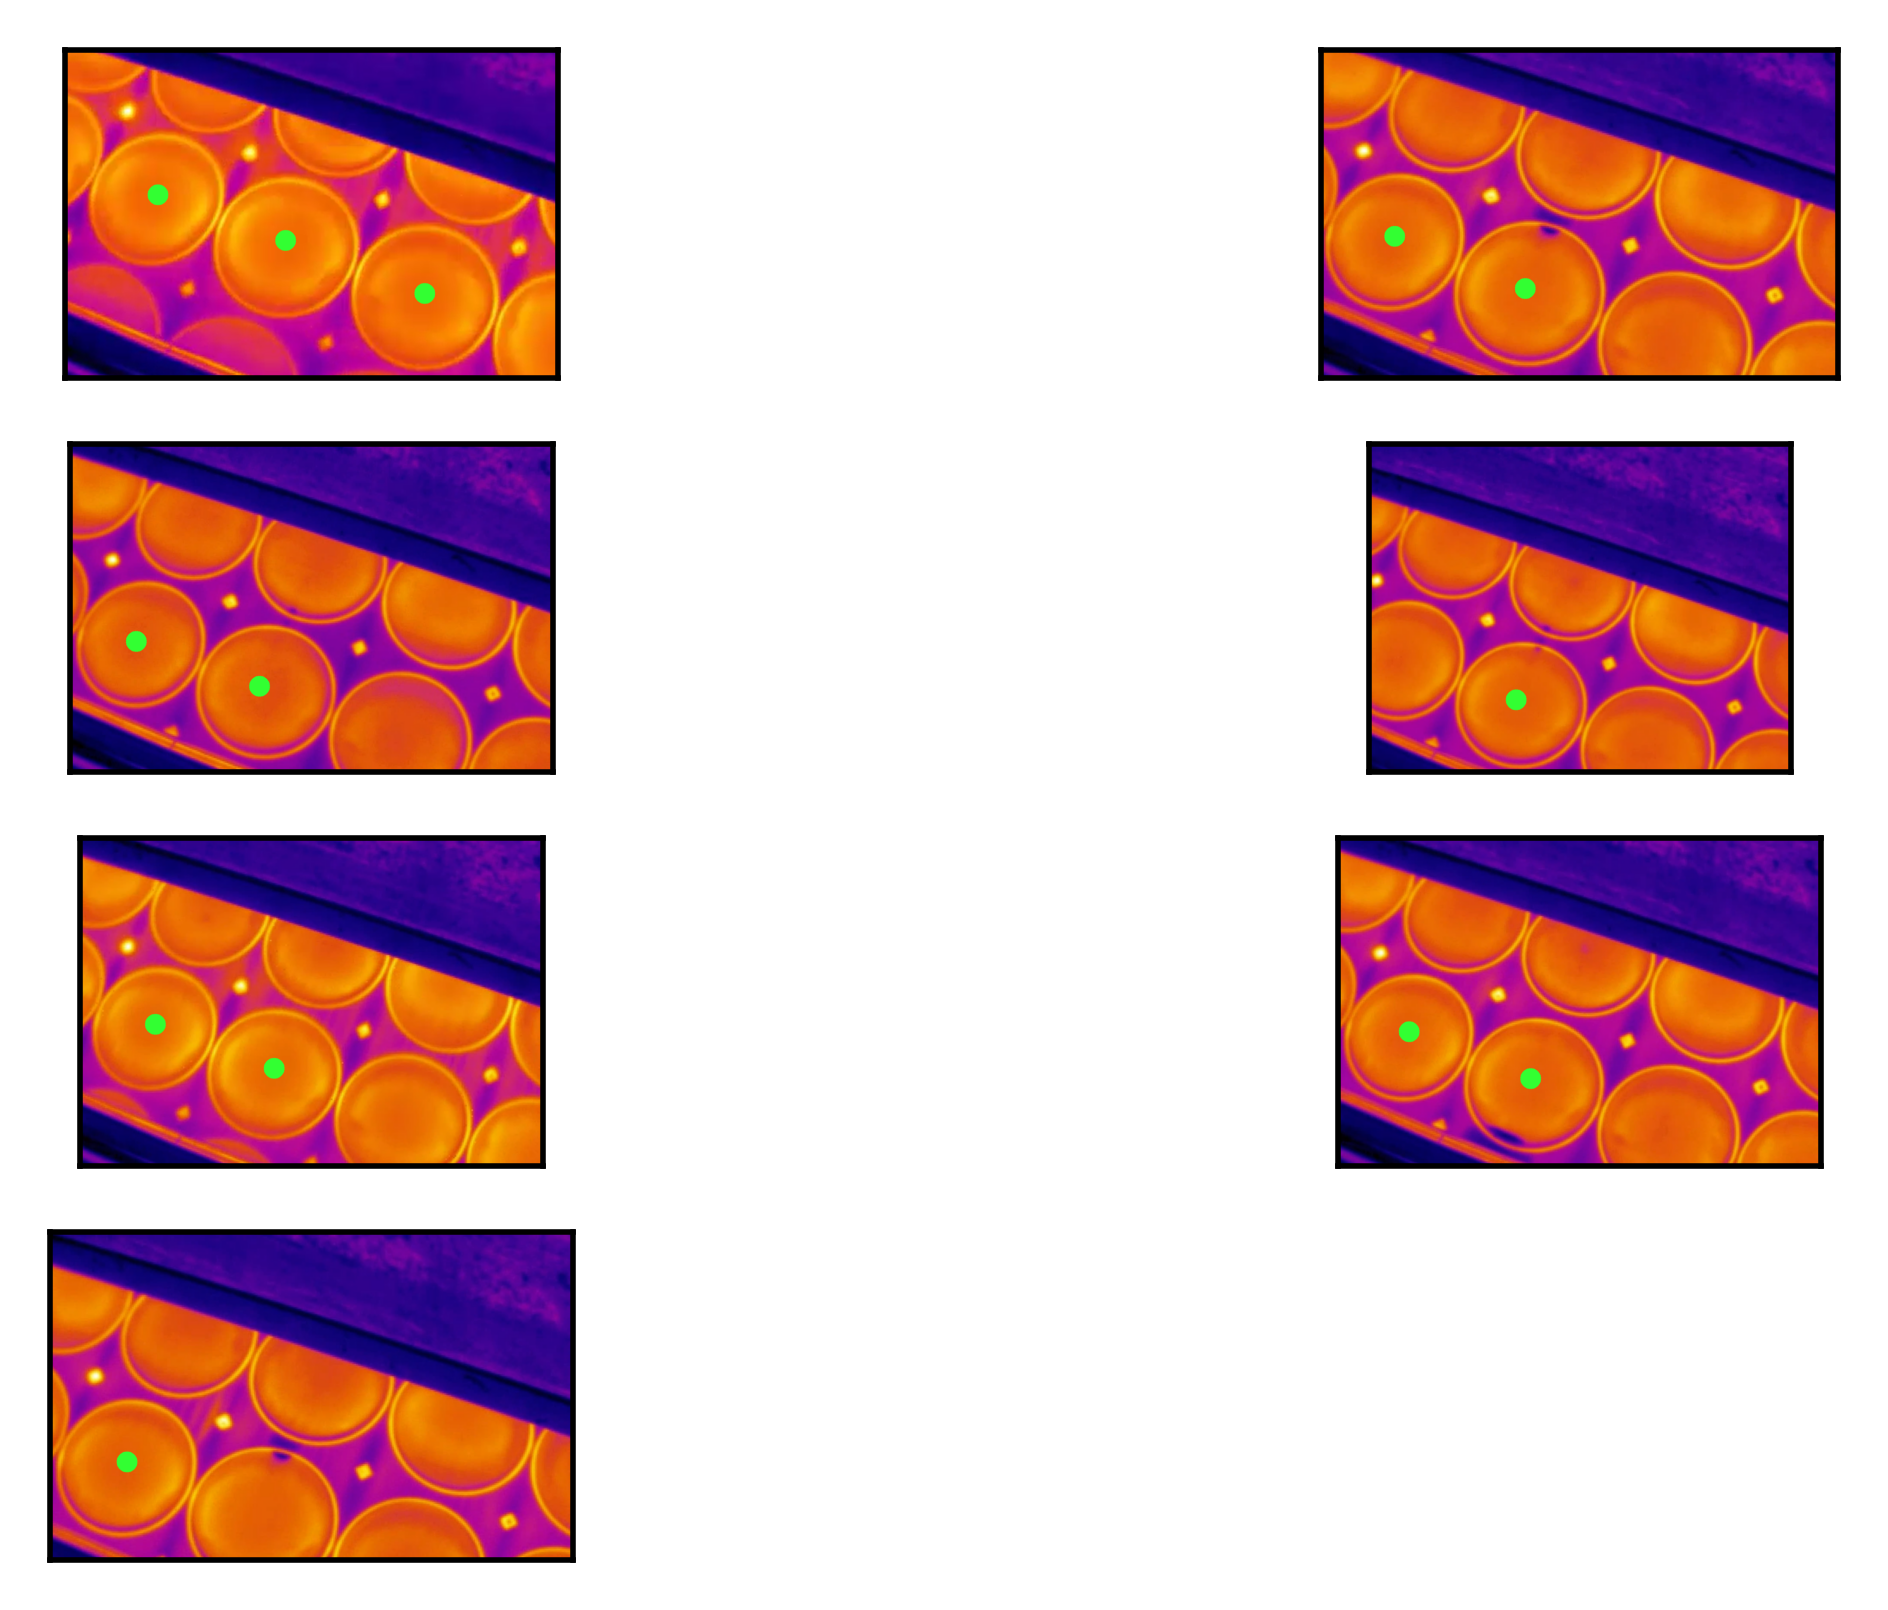

In [27]:
mpl.rcParams['figure.dpi'] = 500
for i in range(7):
    plt.subplot(4, 2, i + 1)
    img_marked = images[i].copy()
    for obj in object_locations[i]:
        # print(int(obj[1], obj[0])
        cv2.circle(img_marked, (int(obj[0]), int(obj[1])), 10, (50, 255, 50), thickness=30)

    plt.imshow(img_marked)
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

### The approach above is sensitive to any small changes, and may not work very robustly if the illumination changes, or when an object is very close to the frame edge. Here, I try another approach

##### Firstly, let's apply some clever preprocessing. We know the approximate color of the objects we are looking for. Let's make the binary image based on how far each pixel's color is from the color of our objects. Then we can apply thresholding to select only pictures, color of which are as close to the one we are looing for as possible

184.3994055480675
179.98518655562944
180.84080856386595
180.32551378506696
180.77150974367112
179.9712630340172
180.2977182302586


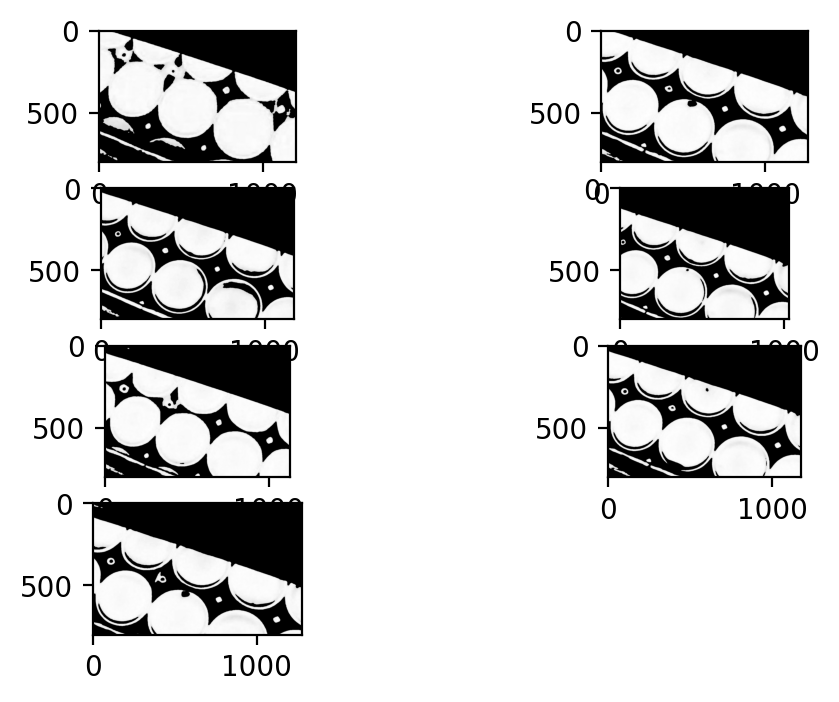

In [28]:
mpl.rcParams['figure.dpi'] = 200
image_idx = 1
grays = []

for image_idx in range(0, 7):
    plt.subplot(4, 2, image_idx + 1)

    img = images[image_idx].copy()
    img = cv2.GaussianBlur(img, (11, 11), 0)
    # img = cv2.GaussianBlur(img, (21, 21), 6)
    # img = cv2.GaussianBlur(img, (31, 31), 10)

    img = img - [50, 165, 241]
    gray = np.linalg.norm(img, axis=2) / 1.73

    print(np.max(gray))
    gray[gray < 155] = 0
    plt.imshow(gray, cmap='gray')
    grays.append(gray)
plt.show()

### Let us try to detect the circles using gaussian blur. We know that if we are looking for a circle, the center pixel of it should have a very high value after performing convolutions with different (not too large, for sure) gaussian filters. Let's try to apply a couple of consecutive filters, threshold values in each of them and choose only pixels that are above the threshold after applying all the filters

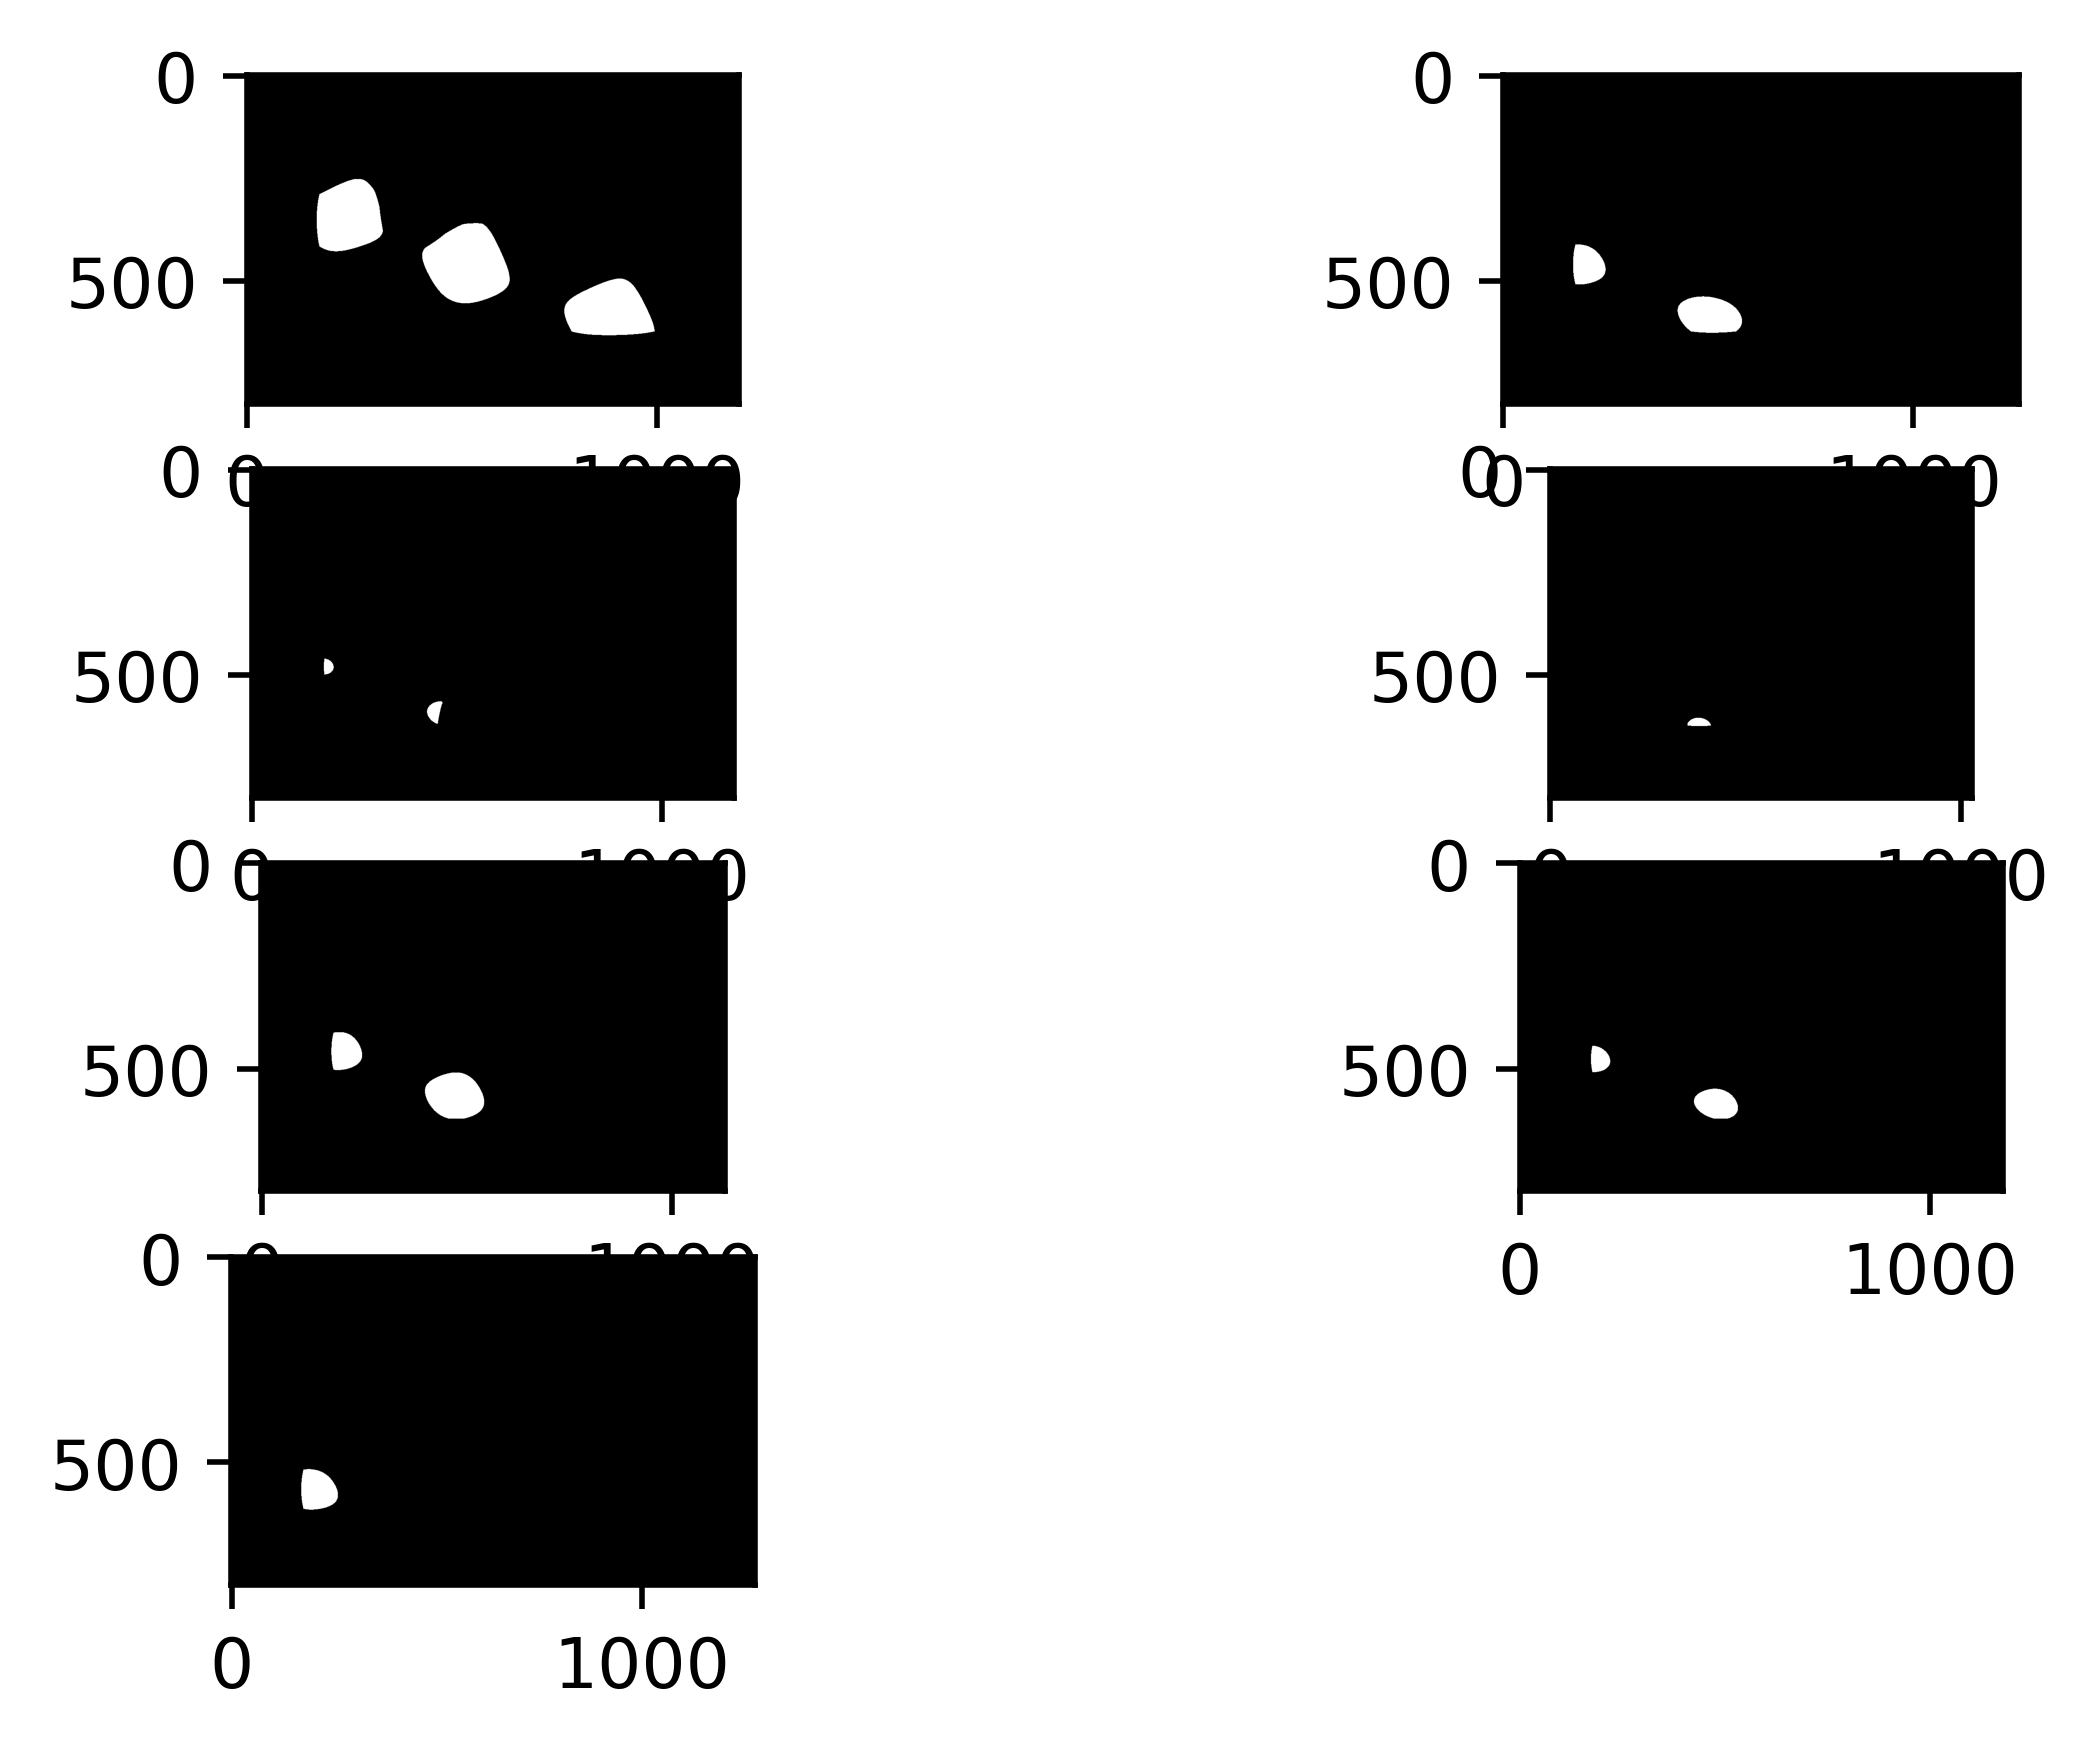

In [35]:
# image = grays[2].copy()
# plt.subplot(2, 2, 1)

object_locations = []

for image_idx in range(0, 7):
    plt.subplot(4, 2, image_idx + 1)

    img = grays[image_idx].copy()
    # Penalize touching bounds of the image
    c = -10000
    img[:, 0] = c
    img[0, :] = c
    img[img.shape[0] - 1, :] = c
    img[:, img.shape[1] - 1] = c

    # Apply a series of Gaussian blurs
    gaussian1 = cv2.GaussianBlur(img, (351, 351), 60, borderType=cv2.BORDER_REPLICATE)
    gaussian1[gaussian1 < 167] = 0
    gaussian1[gaussian1 != 0] = 255

    gaussian2 = cv2.GaussianBlur(img, (351, 351), 40, borderType=cv2.BORDER_REPLICATE)
    gaussian2[gaussian2 < 174] = 0
    gaussian2[gaussian2 != 0] = 255

    gaussian3 = cv2.GaussianBlur(img, (251, 251), 20, borderType=cv2.BORDER_REPLICATE)
    gaussian3[gaussian3 < 174] = 0
    gaussian3[gaussian3 != 0] = 255

    # Perform AND-ing by multiplying. The values are either 255 or 0, so divide by 255 in the end to keep them in this range
    image = (gaussian2 * gaussian1 * gaussian3) / 255 ** 2
    # image = gaussian2

    # Calculate centers of each detected group of pixels
    object_locations.append([])
    image = np.array(image, dtype=np.uint8)
    contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        contour_max = np.max(contour, axis=0)[0]
        contour_min = np.min(contour, axis=0)[0]
        object_locations[-1].append(contour_min + (contour_max - contour_min) // 2)

    plt.imshow(image, cmap='gray')


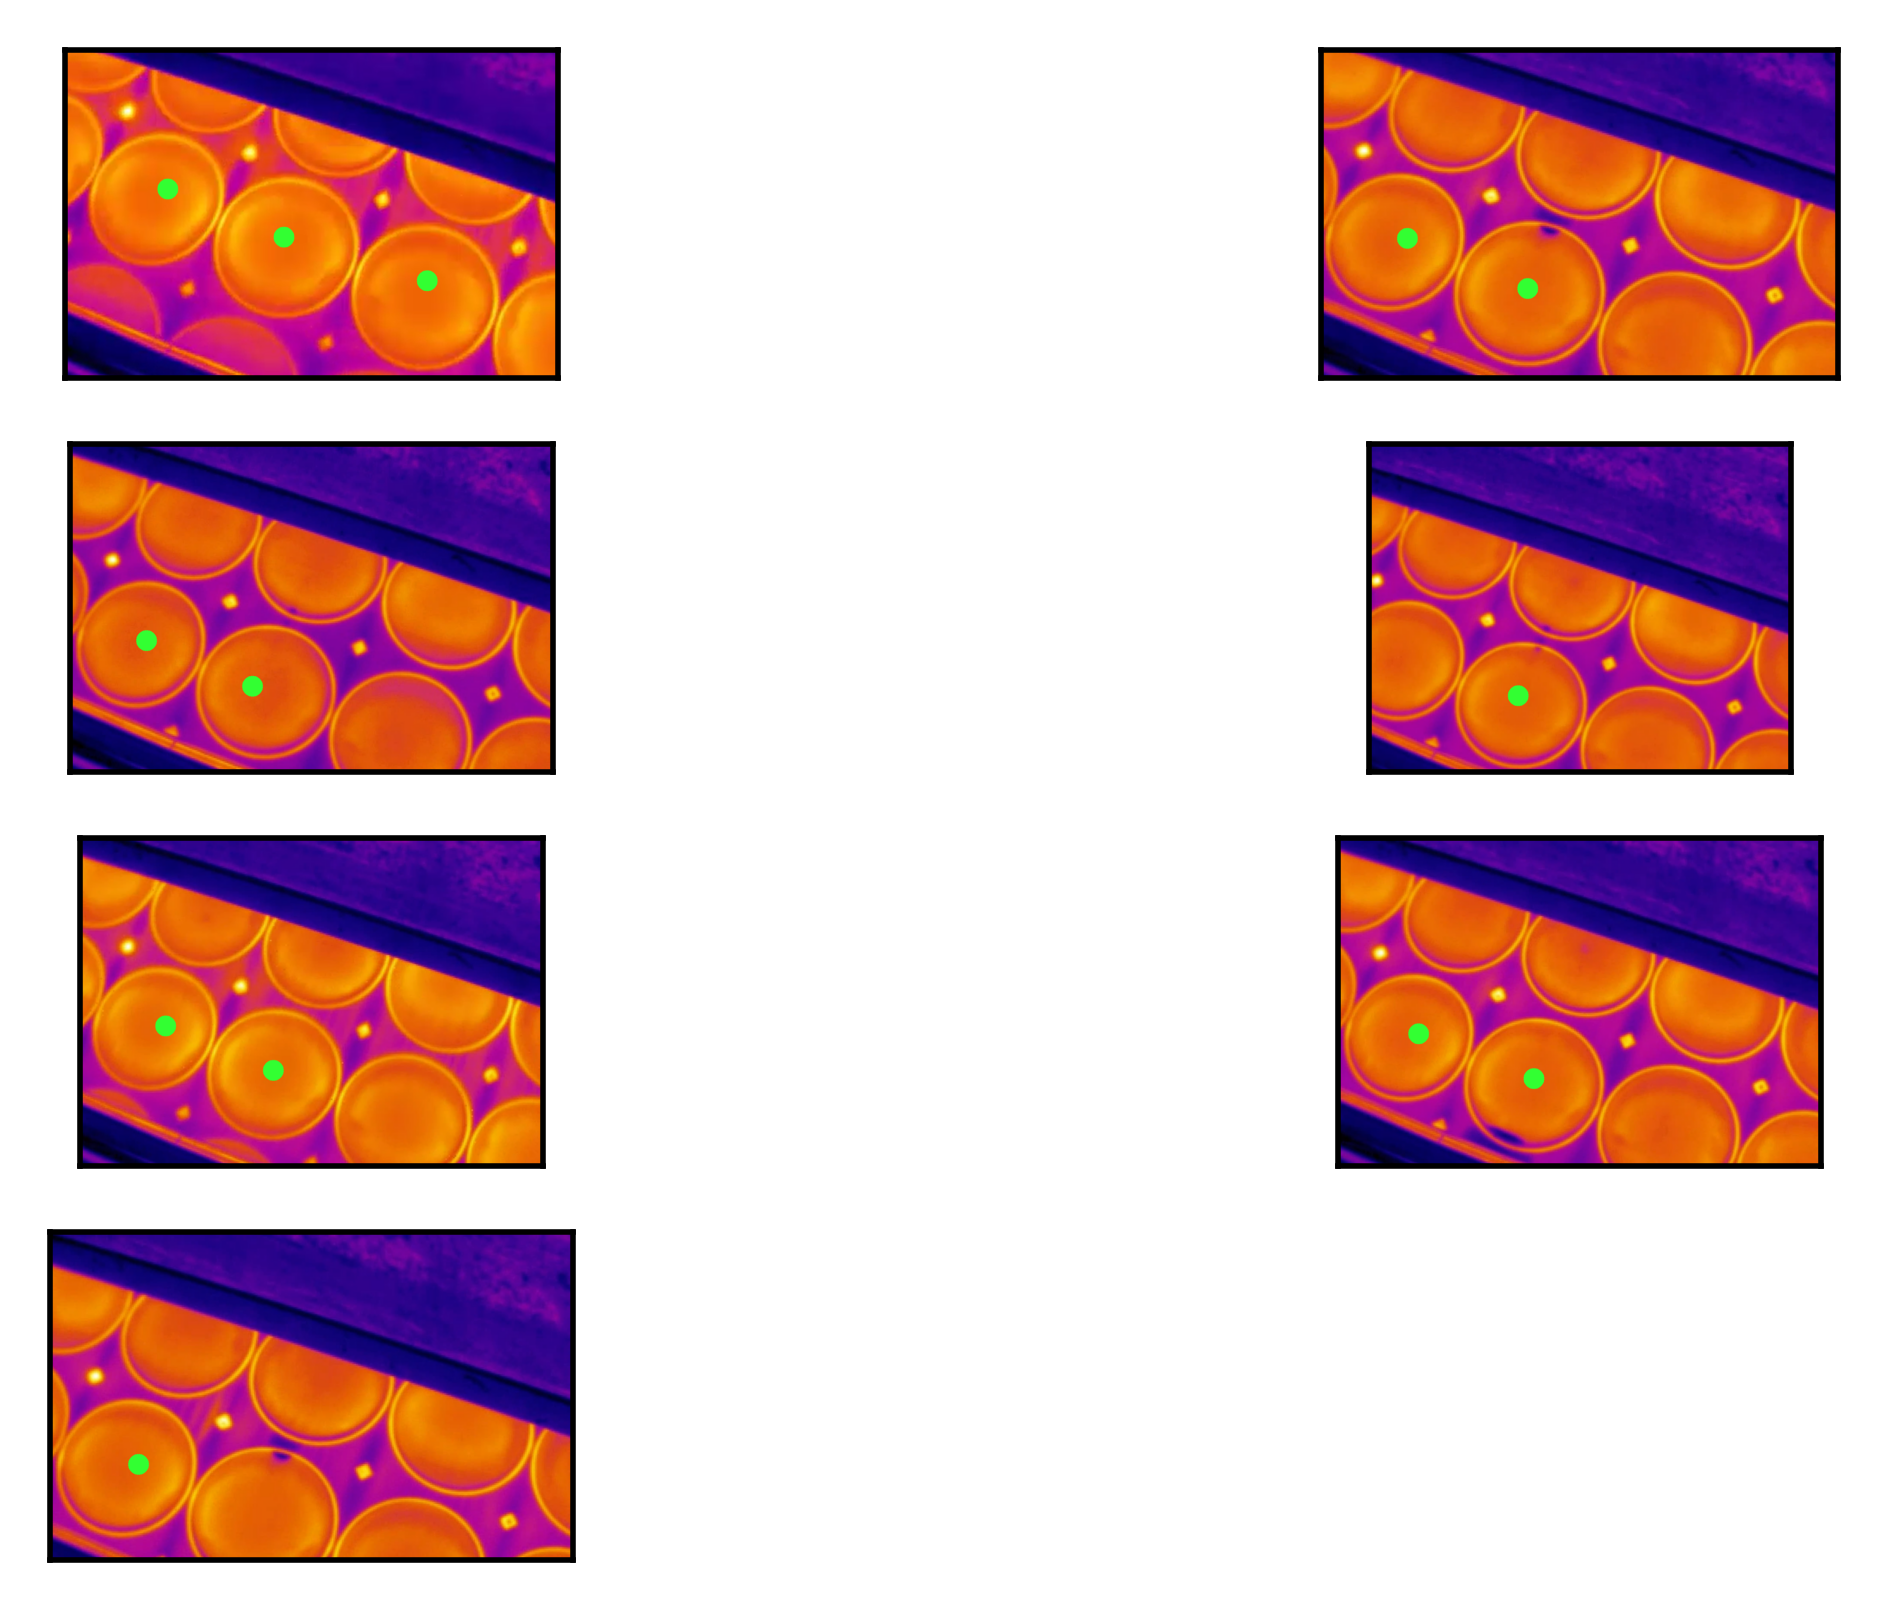

In [36]:
# plot the result
mpl.rcParams['figure.dpi'] = 500
for i in range(7):
    plt.subplot(4, 2, i + 1)
    img_marked = images[i].copy()
    for obj in object_locations[i]:
        cv2.circle(img_marked, (int(obj[0]), int(obj[1])), 10, (50, 255, 50), thickness=30)

    plt.imshow(img_marked)
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

#### This method seems to be working much more robustly. However, anyway, if a small part of the object is not visible because of another object, and not edge of the image, the object is likely to be detected anyway. Also, if the object is not very round, it can be classified as a circle too. In the following section I try a different approach, which is following:
* Use properly tuned Canny edge detection to detect edges of all circles on the image
* Find edges which are long lanes and remove them for better following algorithm quality
* Apply 2D convolution with a "ring" kernel (shown in block below) of different radius and small thickness to precisely detect circles of that radius
* Threshold convolution results to keep only high values - likely center of circles with given radius

#### Example of used kernel

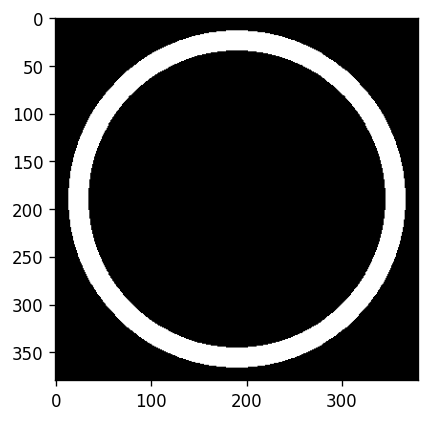

In [172]:
mpl.rcParams['figure.dpi'] = 120
blob_w = 380
blob = np.zeros((blob_w, blob_w), dtype=np.float32)
cv2.circle(blob, (blob_w // 2, blob_w // 2), 166, 1, thickness=20)
blob[blob == 0] = -1
plt.imshow(blob, cmap='gray')

#### Tuning Canny edge detector. Here, I apply pretty large kernel of Gaussian blur to have images more even. For example, the first image is pretty "blured" by default, which is not the case with other images

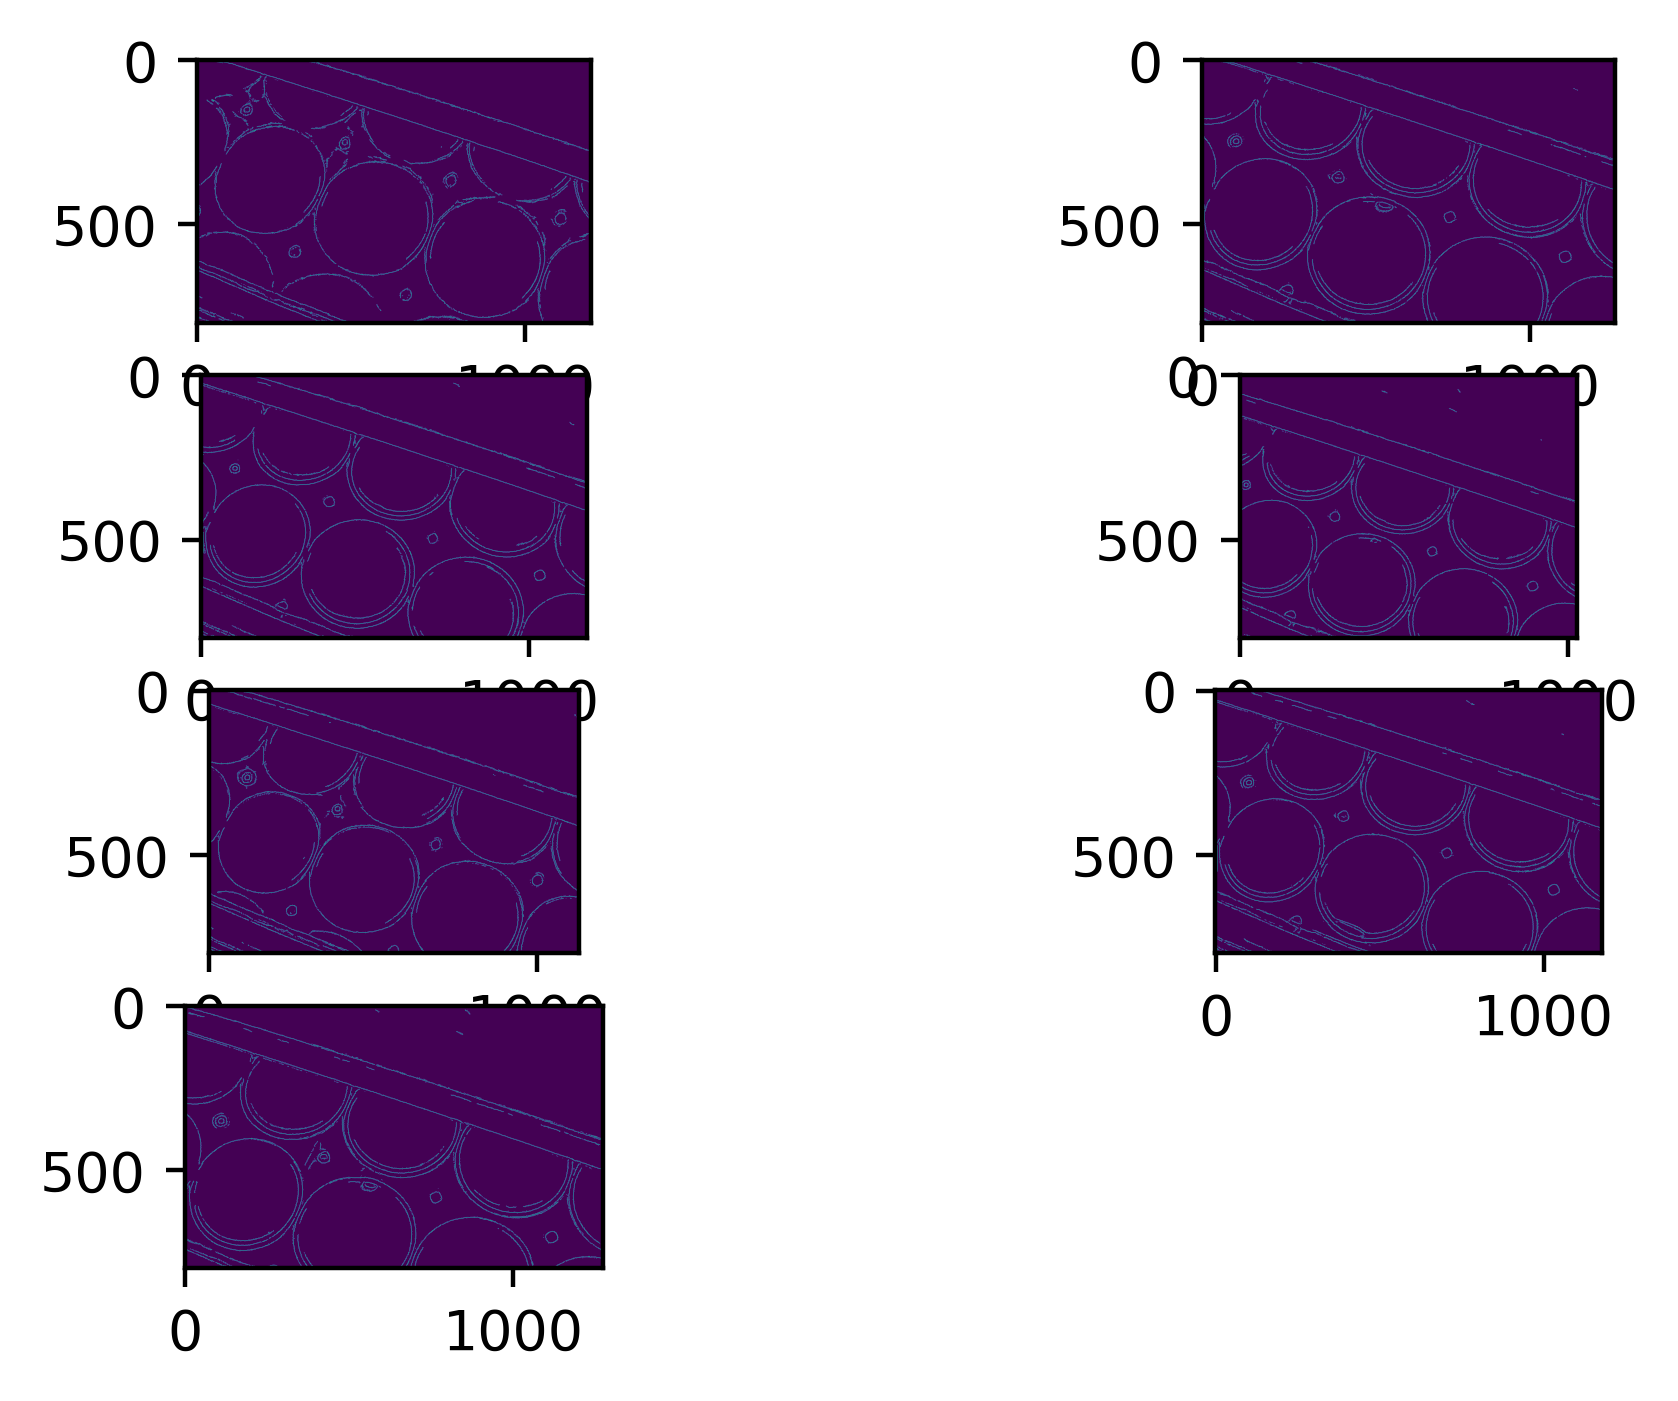

In [147]:
mpl.rcParams['figure.dpi'] = 400

object_locations = []
edges_stores = []

for image_idx in range(7):
    plt.subplot(4, 2, image_idx + 1)
    # Perform Canny edge detection on all the images
    img = images[image_idx].copy()
    img = cv2.GaussianBlur(img, (25, 25), 0)
    img = np.array(img, dtype=np.uint8)
    edges = cv2.Canny(img, 30, 50)
    edges = np.array(edges, dtype=np.float32)

    plt.imshow(edges)
    continue

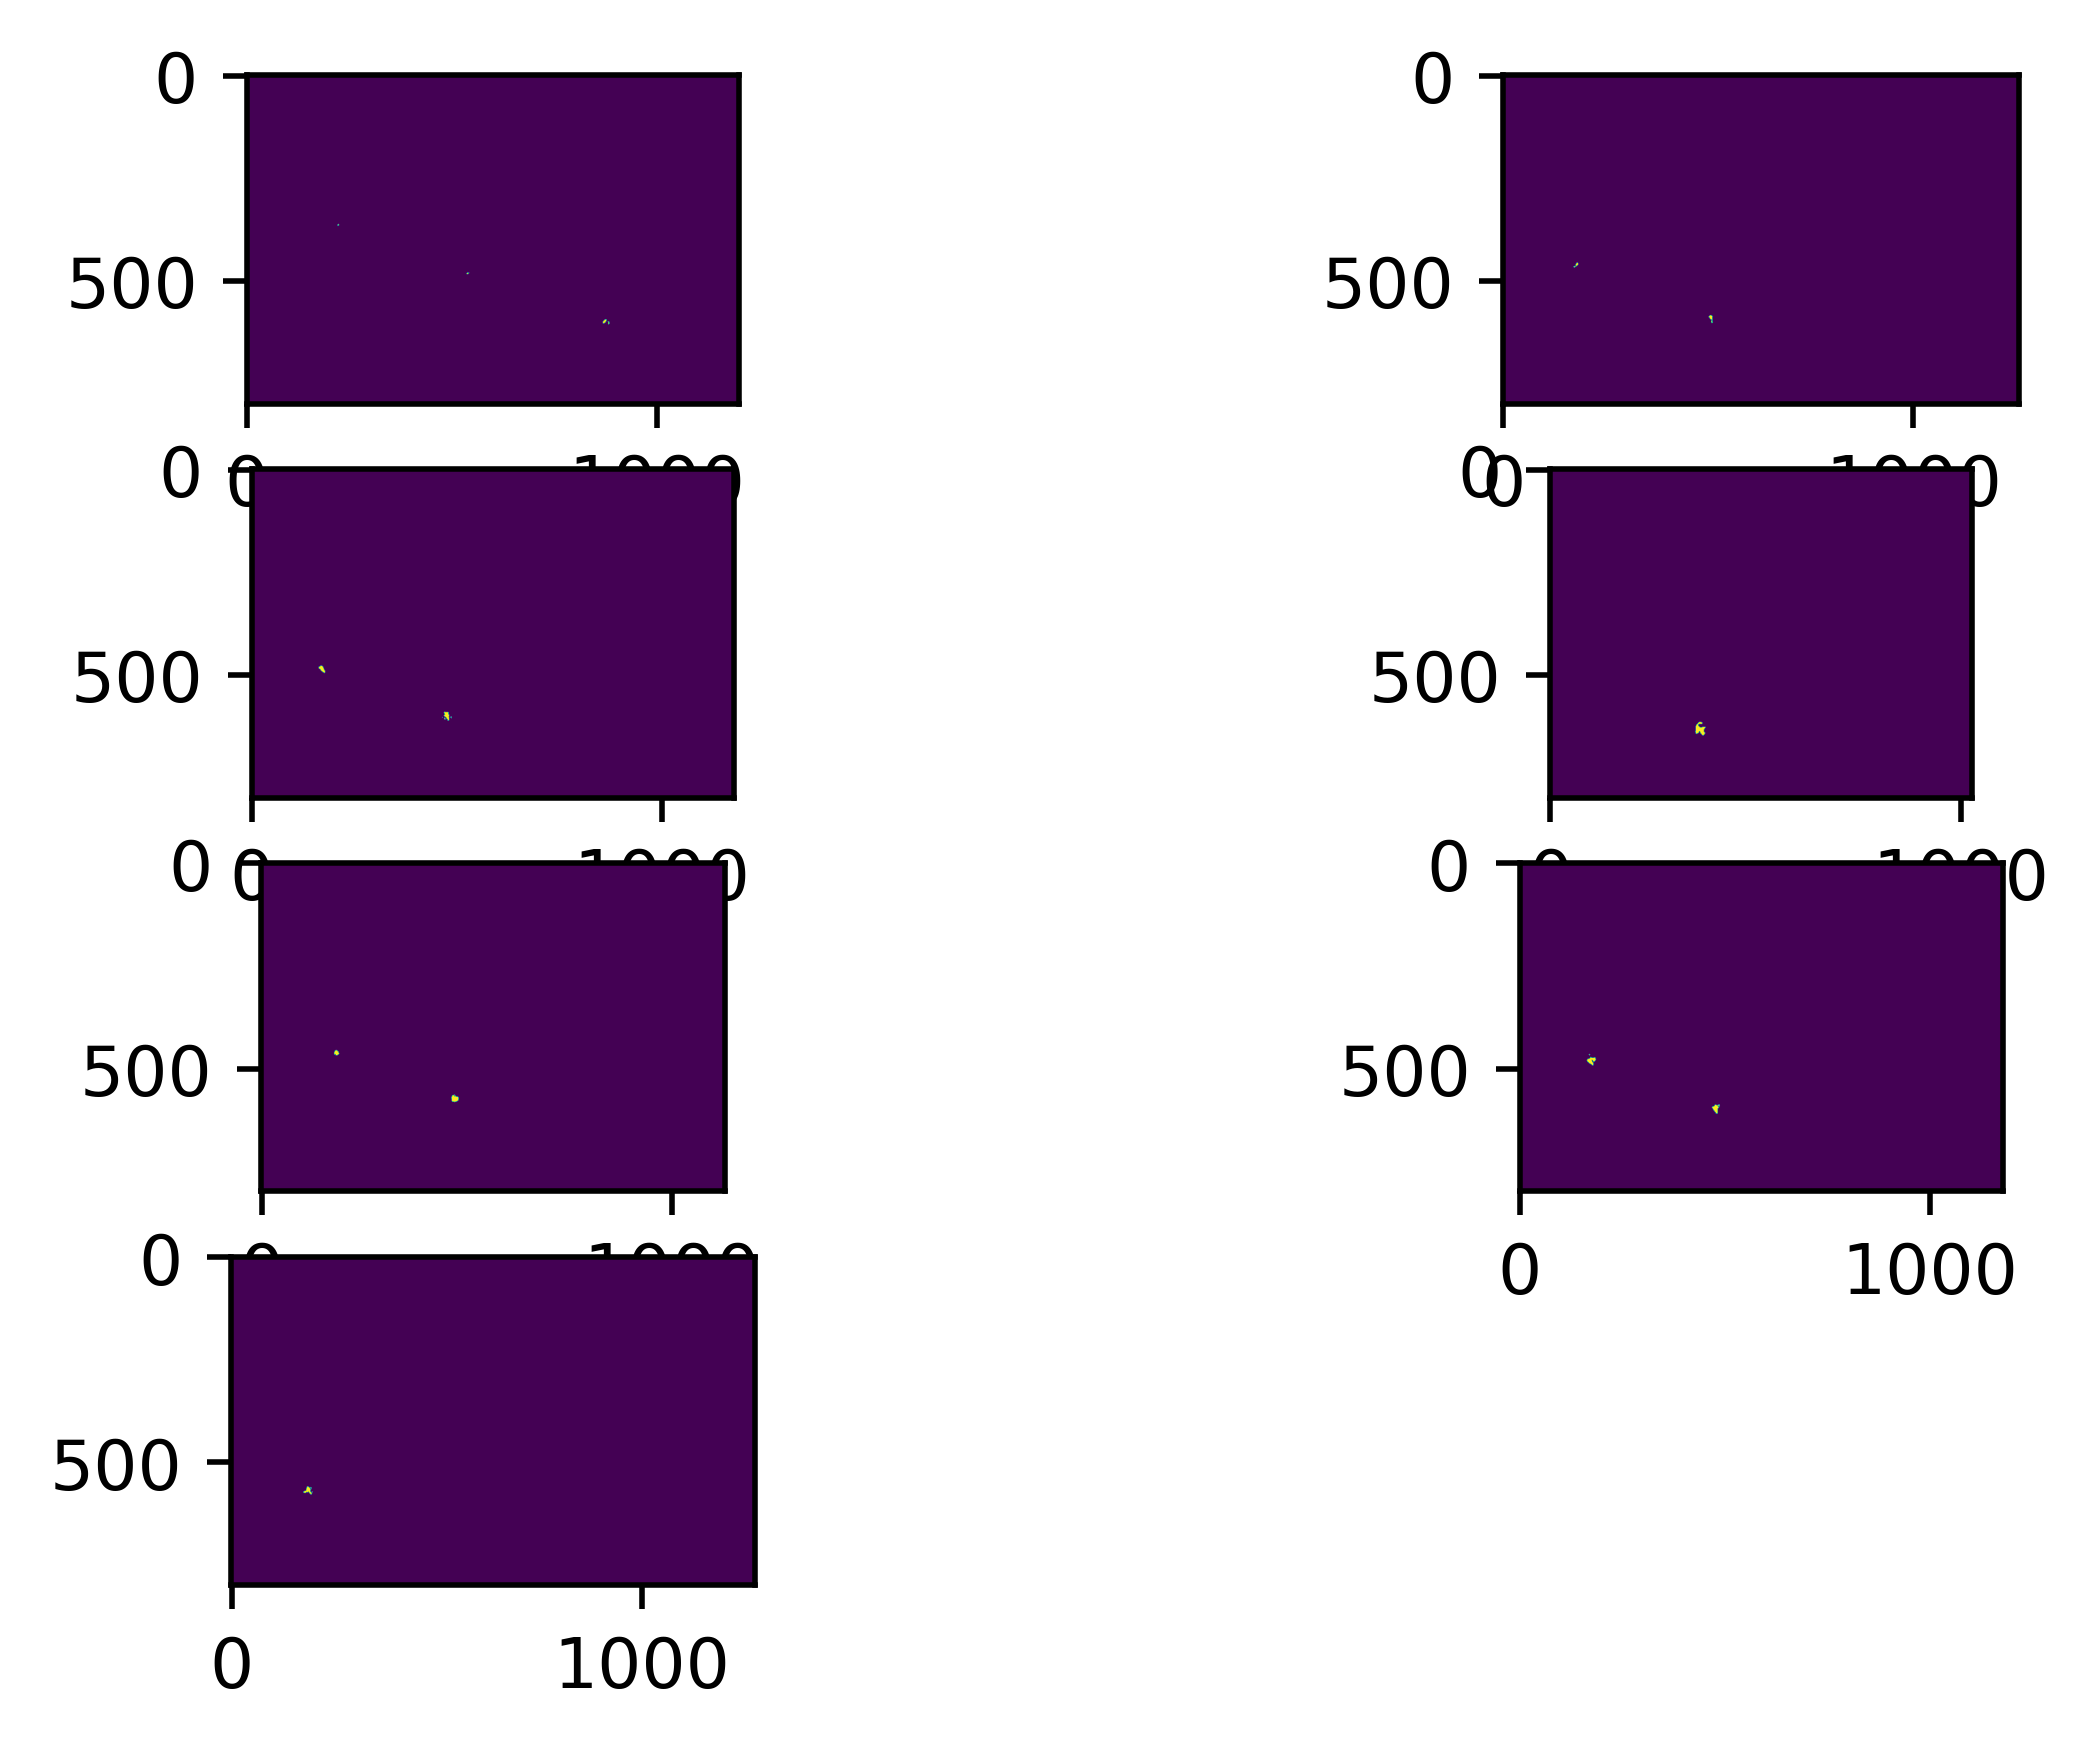

In [170]:
mpl.rcParams['figure.dpi'] = 500

object_locations = []
edges_stores = []

for image_idx in range(7):
    plt.subplot(4, 2, image_idx + 1)

    # Perform Canny edge detection on all the images
    img = images[image_idx].copy()
    img = cv2.GaussianBlur(img, (25, 25), 0)
    img = np.array(img, dtype=np.uint8)
    edges = cv2.Canny(img, 30, 50)
    edges = np.array(edges, dtype=np.float32)

    # If the circle touches the edge of the frame, it is penalized
    c = -100
    edges[:, 0] = c
    edges[0, :] = c
    edges[edges.shape[0] - 1, :] = c
    edges[:, edges.shape[1] - 1] = c

    # Now, detect all long lines among edges
    edges = np.array(edges, dtype=np.uint8)
    rho = 1
    theta = np.pi / 180
    threshold = 25
    min_line_length = 190
    max_line_gap = 20
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    # "Draw" black lines on edges - remove edges that are lines
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(edges, (x1, y1), (x2, y2), 0, 15)

    # Convert to float32 to avoid any overflows during convolutions
    edges[edges != 0] = 1
    edges = np.array(edges, dtype=np.float32)

    # Sum of each convolution
    conv_full = np.zeros_like(edges)

    # Detect circles with radius 155
    blob_w = 400
    blob = np.zeros((blob_w, blob_w), dtype=np.float32)
    cv2.circle(blob, (blob_w // 2, blob_w // 2), 155, 1, thickness=20)
    conv = cv2.filter2D(edges, -1, blob, borderType=cv2.BORDER_REPLICATE)
    conv = conv - np.min(conv)
    conv[conv < 1250] = 0
    conv[conv != 0] = 1
    conv_full = conv_full + conv

     # Detect circles with radius 165
    blob_w = 400
    blob = np.zeros((blob_w, blob_w), dtype=np.float32)
    cv2.circle(blob, (blob_w // 2, blob_w // 2), 165, 1, thickness=20)
    conv = cv2.filter2D(edges, -1, blob, borderType=cv2.BORDER_REPLICATE)
    conv = conv - np.min(conv)
    conv[conv < 1400] = 0
    conv[conv != 0] = 1
    conv_full = conv_full + conv

    # Detect circles with radius 80
    blob_w = 400
    blob = np.zeros((blob_w, blob_w), dtype=np.float32)
    cv2.circle(blob, (blob_w // 2, blob_w // 2), 180, 1, thickness=20)
    conv = cv2.filter2D(edges, -1, blob, borderType=cv2.BORDER_REPLICATE)
    conv = conv - np.min(conv)
    conv[conv < 1680] = 0
    conv[conv != 0] = 1
    conv_full = conv_full + conv

    # Some pixels were added a couple of times, so clip values to be either 0 or 1
    conv_full = np.clip(conv_full, 0, 1)
    plt.imshow(conv_full)

    # Calculate centers of each detected group of pixels
    object_locations.append([])

    image = np.array(conv, dtype=np.uint8)
    conv[conv_full != 0] = 255
    conv_full = np.array(conv_full, dtype=np.uint8)
    contours, _ = cv2.findContours(conv_full, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        contour_max = np.max(contour, axis=0)[0]
        contour_min = np.min(contour, axis=0)[0]
        object_locations[-1].append(contour_min + (contour_max - contour_min) // 2)

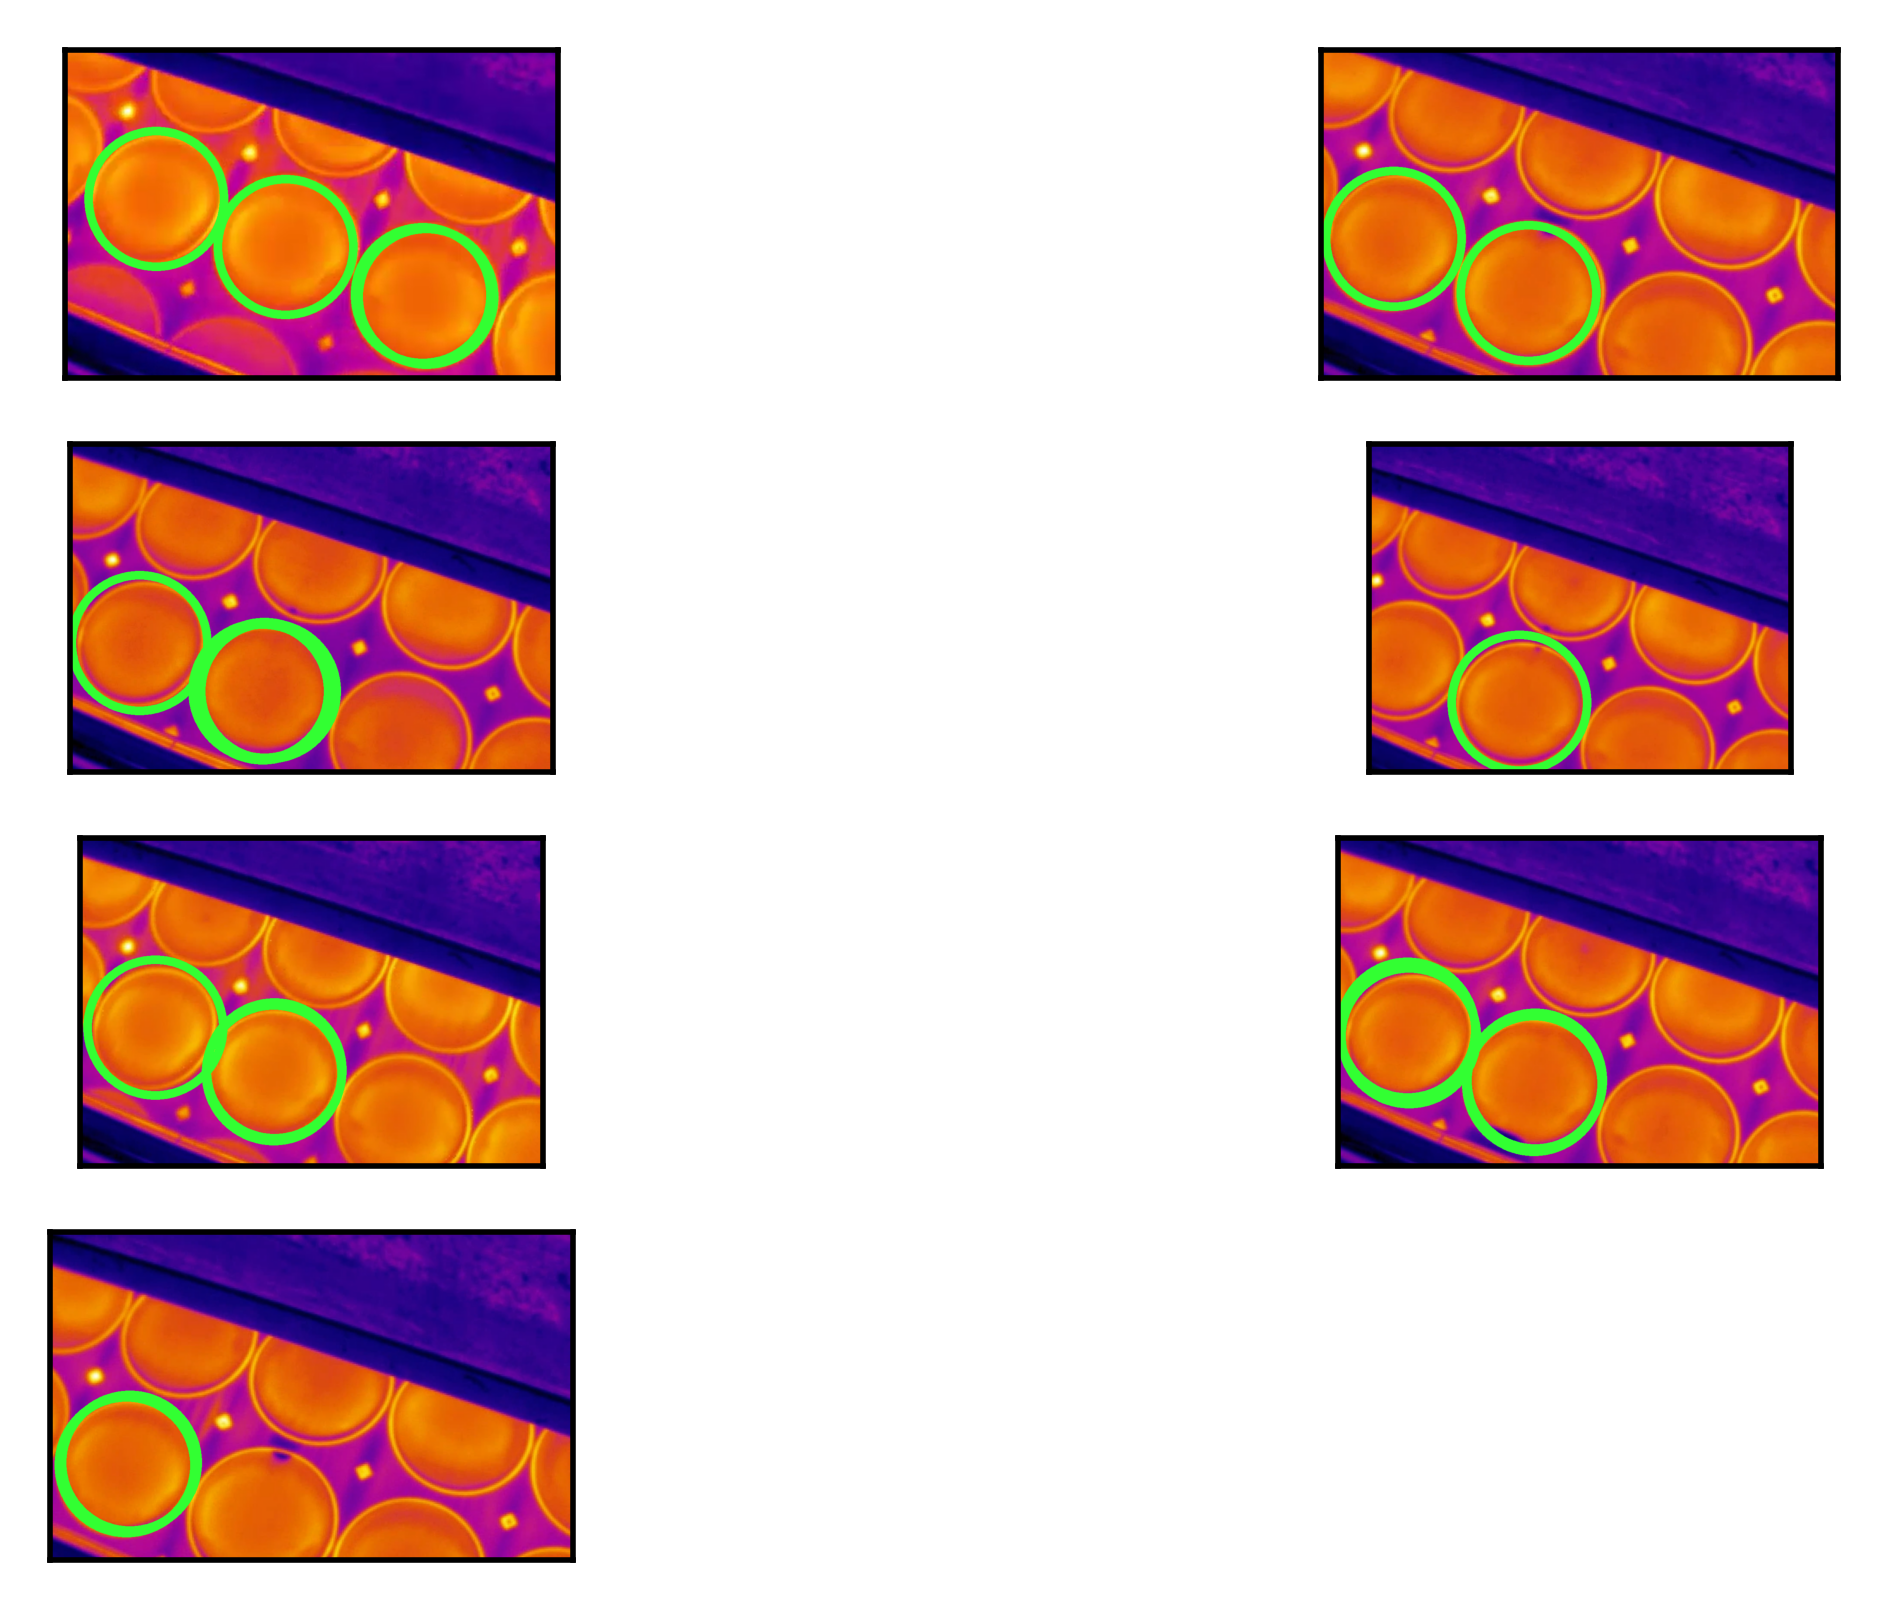

In [171]:
# plot the result
mpl.rcParams['figure.dpi'] = 500
for i in range(7):
    plt.subplot(4, 2, i + 1)
    img_marked = images[i].copy()
    for obj in object_locations[i]:
        # cv2.circle(img_marked, (int(obj[0]), int(obj[1])), 10, (50, 255, 50), thickness=30)
        cv2.circle(img_marked, (int(obj[0]), int(obj[1])), 165, (50, 255, 50), thickness=20)

    plt.imshow(img_marked)
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

### The last seems to be pretty robust. It takes into account the fact that we are looking specifically for circles, so if a part of the object is not visible, it will miss a big amount of arc edge, which will lead to small value after convolution and discarding such object.